# Imports

In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import collections

# Degree Network

Create a network with a desired degree - code start taken from lecture and ChatGPT was used to help create a working version. Link to chat: https://chat.openai.com/share/6d50a46c-cb21-4e5d-9173-7e5b37c031d3


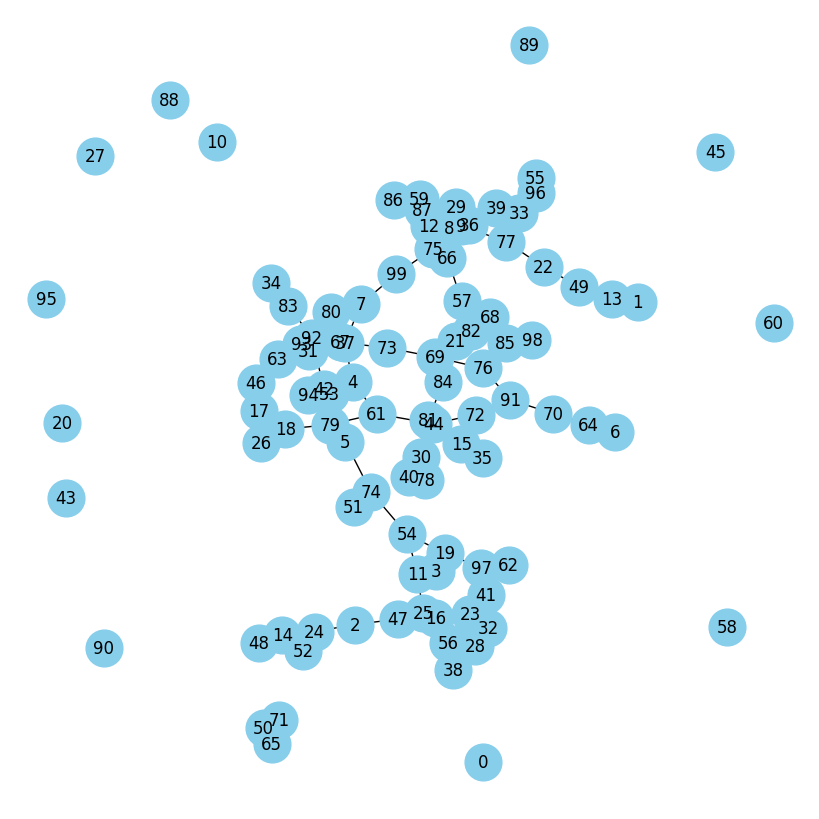

In [2]:


def configuration_A(S):
    """Configuration model with degree sequence S"""
    stubs = []
    for i in range(len(S)):
        for j in range(S[i]):
            stubs.append(i)
    n = nx.Graph()
    n.add_nodes_from(range(len(S)))  # Ensure the graph has len(S) nodes
    while len(stubs) > 1:  # Need at least 2 stubs to form an edge
        v, w = random.sample(stubs, 2)
        if v != w:  # Avoid self-loops
            n.add_edge(v, w)
            # Remove v, w from stubs
            stubs.remove(v)
            stubs.remove(w)
    return n

def configuration_B(n, P):
    """Configuration model with degree distribution P"""
    S = [1]
    while not nx.is_valid_degree_sequence_erdos_gallai(S):
        S = random.choices(population=range(len(P)), weights=P, k=n)
    return configuration_A(S)
def plot_graph(G):
    """Plot the given graph G using matplotlib"""
    plt.figure(figsize=(8, 8))
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, edge_color='k')
    plt.show()


def plot_degree_distribution(G, P):
    """Plot the degree distribution of graph G and compare it with distribution P"""
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    # Also plot the theoretical distribution P for comparison
    theoretical_degrees = range(len(P))
    plt.plot(theoretical_degrees, [p*n for p in P], 'r-', label='Theoretical distribution')
    plt.legend()
    plt.show()



n = 100  # Number of nodes
P = [0.1, 0.2, 0.3, 0.4]  # Example distribution for demonstration


graph = configuration_B(n, P)
plot_graph(graph)

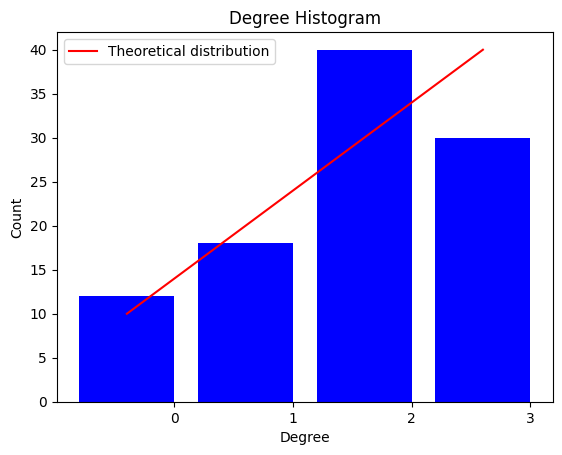

In [3]:
plot_degree_distribution(graph, P)

# Model3

Fits clustering and check with r and d

In [4]:
import networkx as nx
import random
import time
import signal

# Timeout handler
class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException

def model3(G, c_current, cluster, allowed_error, nodes_per_round, seed=42):
    # Seed the random number generator for reproducibility
    random.seed(seed)
    
    c_steps = [c_current]
    cluster_bound = [cluster - allowed_error, cluster + allowed_error]
    i = 0
    start_time = time.time()

    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(3600)  # Set the alarm for one hour

    try:
        while c_current < cluster_bound[0] or c_current > cluster_bound[1]:
            i += 1
            node_list = list(G.nodes())  # Refresh the node list

            # Ensure all nodes are connected to the largest component if not connected
            if not nx.is_connected(G):
                largest_cc = max(nx.connected_components(G), key=len)
                for node in node_list:
                    if node not in largest_cc:
                        G.add_edge(node, random.choice(list(largest_cc)))

            for node in node_list:
                if node not in G:
                    continue  # Ensure node still exists

                current_links = list(G.neighbors(node))
                node_degree = G.degree(node)

                if current_links:
                    # Randomly selects one link to remove
                    link_to_remove = random.choice(current_links)
                    degree_of_removed_node = G.degree(link_to_remove)  # Degree of the node at the other end of the removed link
                    G.remove_edge(node, link_to_remove)

                # Filter nodes with similar degree to the removed node's degree
                possible_new_links = [n for n in node_list if G.degree(n) == degree_of_removed_node and n != node]

                if len(possible_new_links) > nodes_per_round:
                    selected_nodes = random.sample(possible_new_links, nodes_per_round)
                else:
                    selected_nodes = possible_new_links

                c_possible = []

                for possible in selected_nodes:
                    G.add_edge(node, possible)
                    new_c = nx.average_clustering(G)
                    c_possible.append(new_c)
                    G.remove_edge(node, possible)

                if c_possible:
                    best_node = selected_nodes[c_possible.index(max(c_possible))]
                    G.add_edge(node, best_node)

            c_current = nx.average_clustering(G)
            c_steps.append(c_current)

        signal.alarm(0)  # Disable the alarm
        execution_time = time.time() - start_time
        print(f"Total execution time: {execution_time:.2f} seconds")
        return G, i, c_steps

    except TimeoutException:
        print("Function execution failed due to timeout.")
        execution_time = time.time() - start_time
        print(f"Total execution time: {execution_time:.2f} seconds")
        return G, i, c_steps  # Returning the graph, iteration count, and clustering steps so far

# Example usage:
# G = nx.complete_graph(50)  # or any other graph initialization
# result = model3(G, nx.average_clustering(G), 0.6, 0.02, 5)

In [5]:
# check how good the model is


def analyze_graph(G):
    # Check if the graph is connected; this is required to compute the diameter
    if nx.is_connected(G):
        diameter = nx.diameter(G)
        print(f"Diameter of the graph: {diameter}")
    else:
        print("Graph is not connected; diameter of the giant component will be calculated.")
        # Find the largest connected component (giant component)
        giant_component = max(nx.connected_components(G), key=len)
        G_giant = G.subgraph(giant_component).copy()

        # Diameter of the giant component
        diameter = nx.diameter(G_giant)
        print(f"Diameter of the giant component: {diameter}")


    # Average Clustering Coefficient
    avg_clustering = nx.average_clustering(G)
    print(f"Average Clustering Coefficient: {avg_clustering}")

    # Degree Distribution
    degrees = [G.degree(n) for n in G.nodes()]
    degree_counts = np.bincount(degrees)
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(degree_counts)), degree_counts, width=0.80, color='b')
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()


In [6]:
import pandas as pd
# Meet's stuff
Sydney = pd.read_csv("Sydney.csv")
SiouxFalls = pd.read_csv("SiouxFalls.csv")
Anaheim = pd.read_csv("Anaheim.csv")
BerlinFriedrichshain = pd.read_csv("Berlin-Friedrichshain.csv")
BerlinMitteCenter = pd.read_csv("Berlin-Mitte-Center.csv")
Barcelona = pd.read_csv("Barcelona.csv")
EasternMassachusetts = pd.read_csv("Eastern-Massachusetts.csv")
Winnipeg = pd.read_csv("Winnipeg.csv")

In [7]:
ana_net = bar_net = bf_net = bmc_net = em_net = sioux_net = syd_net = win_net = nx.Graph()

places = [Anaheim, Barcelona, BerlinFriedrichshain, BerlinMitteCenter, EasternMassachusetts, SiouxFalls, Sydney, Winnipeg]
graphs = [ana_net, bar_net, bf_net, bmc_net, em_net, sioux_net, syd_net, win_net]

for i in range(len(places)):
  for idx, row in places[i].iterrows():
    graphs[i].add_edge(row['init_node'], row['term_node'], **row.drop(['init_node', 'term_node']).to_dict())

In [8]:
# get a degree distribution from Eastern Massachusetts
em_degrees = [em_net.degree(n) for n in em_net.nodes()]
em_degree_counts = np.bincount(em_degrees)

In [9]:
# make that random model with that
em_graph = configuration_B(74, em_degree_counts)

In [10]:
em_graph_avg = nx.average_clustering(em_graph)

In [11]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.2869
em_model, em_i, em_c_steps = model3(em_graph, em_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.02 seconds


In [12]:
em_model

In [13]:
em_i

46048

In [14]:
em_c_steps

[0.06351013851013851,
 0.1250565500565501,
 0.09478764478764479,
 0.1244315744315744,
 0.09347919347919346,
 0.07453882453882454,
 0.08748391248391248,
 0.08885671385671386,
 0.07173959673959675,
 0.09504504504504506,
 0.15225225225225222,
 0.08084513084513083,
 0.14050836550836548,
 0.09540969540969539,
 0.07710015210015211,
 0.08896396396396396,
 0.06543329043329042,
 0.06544401544401544,
 0.05143715143715144,
 0.11853281853281854,
 0.07708065208065207,
 0.10085800085800085,
 0.15415057915057914,
 0.0682110682110682,
 0.1173101673101673,
 0.05762548262548262,
 0.10608108108108107,
 0.10704633204633204,
 0.11973401973401974,
 0.13256113256113258,
 0.15408622908622904,
 0.04632132132132133,
 0.07905405405405404,
 0.028314028314028315,
 0.07593307593307594,
 0.06579794079794081,
 0.08346203346203346,
 0.05685328185328185,
 0.05363577863577864,
 0.05382882882882883,
 0.09971042471042471,
 0.08806306306306308,
 0.05415057915057915,
 0.037246987246987245,
 0.06315958815958816,
 0.095431145

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 8
Average Clustering Coefficient: 0.11406048906048905


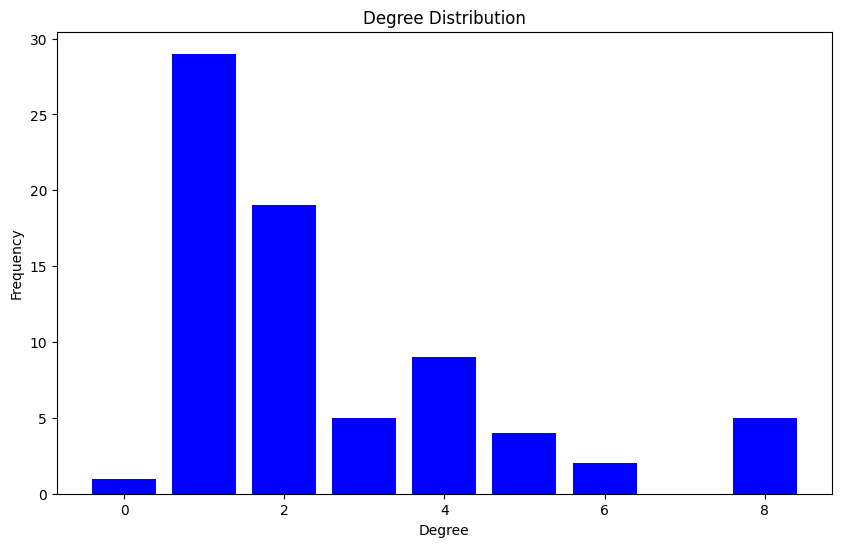

In [15]:
# compare calculated d and r values with actual values
analyze_graph(em_model)

In [16]:
nx.degree_assortativity_coefficient(em_model)

-0.2698220891970774

In [17]:
# get a degree distribution from Sioux Falls
sioux_degrees = [sioux_net.degree(n) for n in sioux_net.nodes()]
sioux_degree_counts = np.bincount(sioux_degrees)

In [18]:
# make that random model with that
sioux_graph = configuration_B(24, sioux_degree_counts)

In [19]:
sioux_graph_avg = nx.average_clustering(sioux_graph)

In [20]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.0528
sioux_model, sioux_i, sioux_c_steps = model3(sioux_graph, sioux_graph_avg, c, c * 0.1, 5)

Total execution time: 0.32 seconds


In [21]:
sioux_model

In [22]:
sioux_i

46

In [23]:
sioux_c_steps

[0.4013888888888888,
 0.1402777777777778,
 0.25416666666666665,
 0.21388888888888882,
 0.09027777777777779,
 0.09444444444444444,
 0.14722222222222223,
 0.15277777777777776,
 0.14444444444444446,
 0.12222222222222223,
 0.03194444444444444,
 0.17500000000000002,
 0.024999999999999998,
 0.11944444444444445,
 0.19285714285714284,
 0.1680555555555556,
 0.13333333333333333,
 0.0,
 0.0,
 0.09722222222222222,
 0.15972222222222224,
 0.0,
 0.14166666666666666,
 0.1722222222222222,
 0.14027777777777778,
 0.08194444444444444,
 0.075,
 0.09027777777777778,
 0.2222222222222222,
 0.0,
 0.0,
 0.18888888888888888,
 0.012499999999999999,
 0.03611111111111111,
 0.33988095238095245,
 0.0,
 0.16111111111111112,
 0.27638888888888885,
 0.13333333333333333,
 0.19861111111111115,
 0.059722222222222225,
 0.059722222222222225,
 0.13749999999999998,
 0.23055555555555554,
 0.18611111111111112,
 0.14583333333333331,
 0.049999999999999996]

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 7
Average Clustering Coefficient: 0.049999999999999996


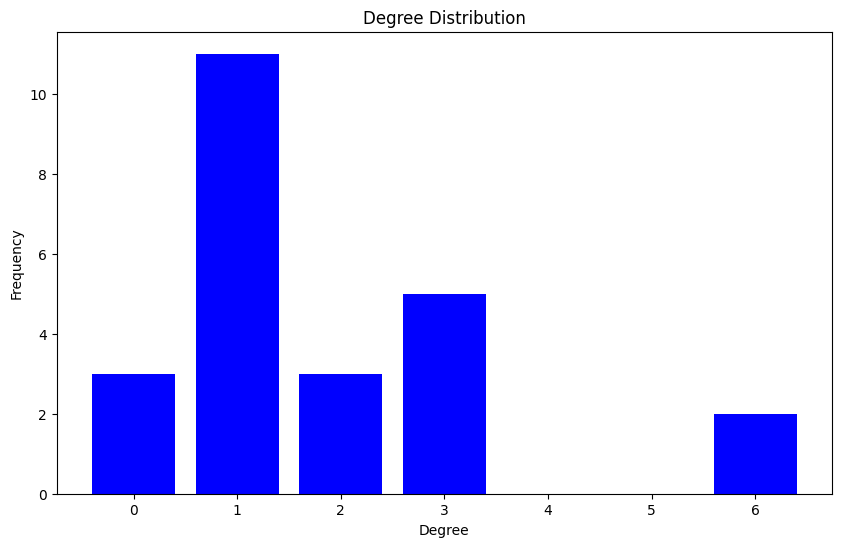

In [24]:
# compare calculated d and r values with actual values
analyze_graph(sioux_model)

In [25]:
nx.degree_assortativity_coefficient(sioux_model)

-0.0987224157955864

In [26]:
# get a degree distribution from Barcelona
bar_degrees = [bar_net.degree(n) for n in bar_net.nodes()]
bar_degree_counts = np.bincount(bar_degrees)

In [27]:
# make that random model with that
bar_graph = configuration_B(1020, bar_degree_counts)

In [28]:
bar_graph_avg = nx.average_clustering(bar_graph)

In [29]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.0902
bar_model, bar_i, bar_c_steps = model3(bar_graph, bar_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.07 seconds


In [30]:
bar_model

In [31]:
bar_i

129

In [32]:
bar_c_steps

[0.0017498514557338085,
 0.00761041790453555,
 0.013767974944445531,
 0.019055710085121847,
 0.024883683854272094,
 0.02574276486041193,
 0.027859694771459474,
 0.028506408250079725,
 0.026491488817340217,
 0.031974641229756316,
 0.03021818517857492,
 0.01897056529429266,
 0.028086859640795745,
 0.02961202388538028,
 0.027381192851309966,
 0.02308154015012273,
 0.0344625399792947,
 0.02614990499167574,
 0.02816196365765623,
 0.03910912124349333,
 0.04374596359356211,
 0.03939579431194501,
 0.040935894957446116,
 0.035689876445886316,
 0.03441417936327858,
 0.0325995062076219,
 0.036535273079177005,
 0.032290362983467526,
 0.043288307949694634,
 0.03813767187112973,
 0.03863314535157995,
 0.04587033810977942,
 0.039685196072969005,
 0.033273643205577304,
 0.040852851199384504,
 0.037936046871426675,
 0.04172174599817389,
 0.04457684370429542,
 0.04947064968222195,
 0.03795115154724756,
 0.03553475306683523,
 0.04374392974839164,
 0.037539994009761456,
 0.04146736771048758,
 0.0380863670

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 8
Average Clustering Coefficient: 0.042007924807625475


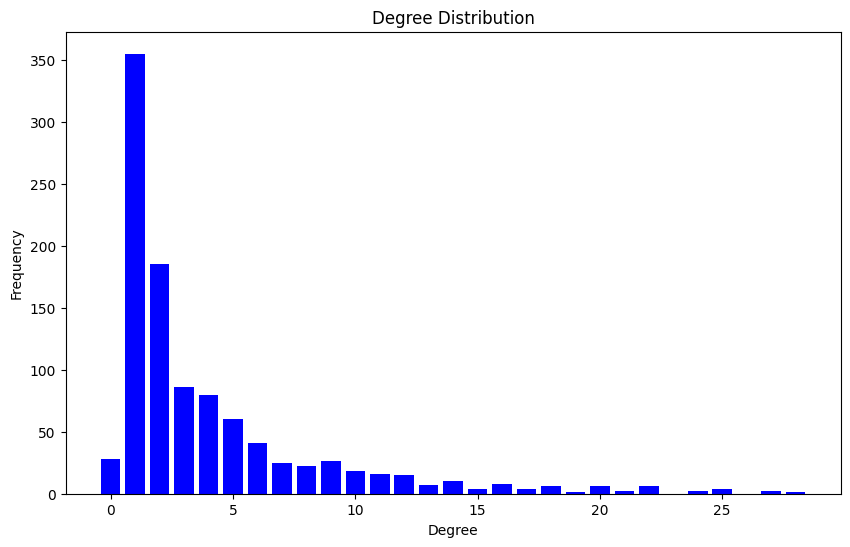

In [33]:
# compare calculated d and r values with actual values
analyze_graph(bar_model)

In [34]:
nx.degree_assortativity_coefficient(bar_model)

-0.42714676590109607

In [35]:
# get a degree distribution from Sydney
syd_degrees = [syd_net.degree(n) for n in syd_net.nodes()]
syd_degree_counts = np.bincount(syd_degrees)

In [36]:
# make that random model with that
syd_graph = configuration_B(33837, syd_degree_counts)

In [37]:
syd_graph_avg = nx.average_clustering(syd_graph)

In [38]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.0074
syd_model, syd_i, syd_c_steps = model3(syd_graph, syd_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.02 seconds


In [39]:
syd_model

In [40]:
syd_i

1

In [41]:
syd_c_steps

[0.00013268754096320166]

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 29
Average Clustering Coefficient: 9.04939177783558e-05


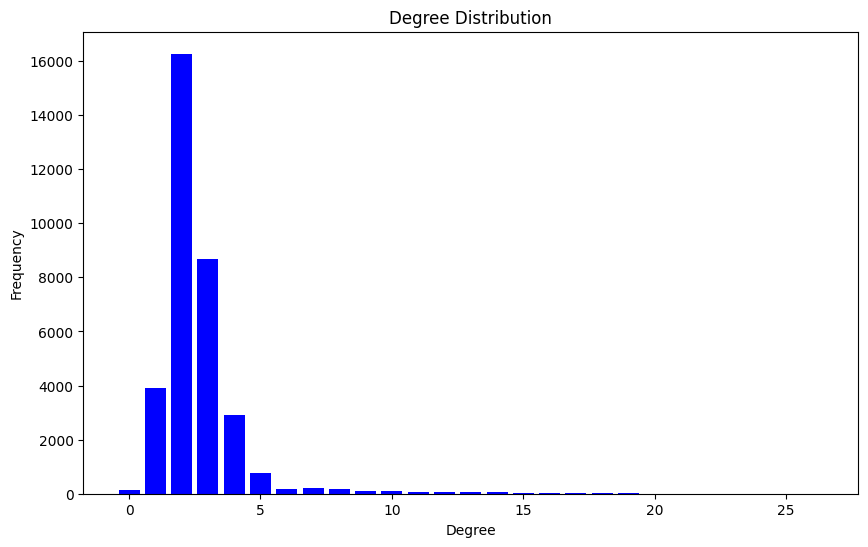

In [42]:
# compare calculated d and r values with actual values
analyze_graph(syd_model)

In [43]:
nx.degree_assortativity_coefficient(syd_model)

-0.012399913865099798

In [44]:
# get a degree distribution from Winnipeg
win_degrees = [win_net.degree(n) for n in win_net.nodes()]
win_degree_counts = np.bincount(win_degrees)

In [45]:
# make that random model with that
win_graph = configuration_B(1052, win_degree_counts)

In [46]:
win_graph_avg = nx.average_clustering(win_graph)

In [47]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.1045
win_model, win_i, win_c_steps = model3(win_graph, win_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.00 seconds


In [48]:
win_model

In [49]:
win_i

122

In [50]:
win_c_steps

[0.001845536781498358,
 0.016173069642651392,
 0.012032016357111413,
 0.018664030308517,
 0.011437836033843634,
 0.019986479262927487,
 0.025711110288106482,
 0.020076755649349198,
 0.027839234841303725,
 0.019839599119667164,
 0.02927586996512048,
 0.04224082040642633,
 0.0365111836913326,
 0.026809341964832326,
 0.038337404894279,
 0.03629699359549232,
 0.034645701840326185,
 0.04258775603485182,
 0.039950853746234596,
 0.03124228633325397,
 0.046381545503990915,
 0.038524143117724785,
 0.047923878034812364,
 0.040207213664906614,
 0.034134028315098375,
 0.03324010084035412,
 0.03491574653777991,
 0.037319427631260574,
 0.03692532371167625,
 0.03264142279199911,
 0.03482102346179812,
 0.03964004217946294,
 0.03666635298608728,
 0.044446487558989514,
 0.03687598584073237,
 0.039560233319330236,
 0.03738243682673581,
 0.0444697090815357,
 0.046141205812964846,
 0.04347554483338776,
 0.04022926218410376,
 0.03408918450115103,
 0.04671561048222281,
 0.044971860062928214,
 0.0392759483434

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 8
Average Clustering Coefficient: 0.04056720756992334


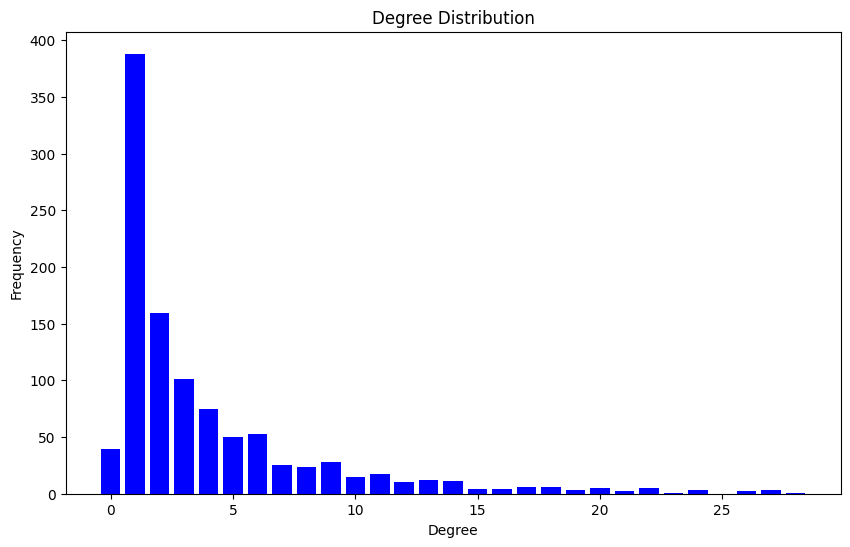

In [51]:
# compare calculated d and r values with actual values
analyze_graph(win_model)

In [52]:
nx.degree_assortativity_coefficient(win_model)

-0.4083234411984343

In [53]:
# get a degree distribution from Anaheim
ana_degrees = [ana_net.degree(n) for n in ana_net.nodes()]
ana_degree_counts = np.bincount(ana_degrees)

In [54]:
# make that random model with that
ana_graph = configuration_B(416, ana_degree_counts)

In [55]:
ana_graph_avg = nx.average_clustering(ana_graph)

In [56]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.1076
ana_model, ana_i, ana_c_steps = model3(ana_graph, ana_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.06 seconds


In [57]:
ana_model

In [58]:
ana_i

1083

In [59]:
ana_c_steps

[0.00921474358974359,
 0.012792589355089352,
 0.01455298174048174,
 0.04427210076248537,
 0.038632361228515065,
 0.028967386779886767,
 0.057761868755929854,
 0.06850964206733438,
 0.052371476091781506,
 0.05657911799738721,
 0.046670857187684094,
 0.04921979729672039,
 0.05598619512367575,
 0.05285920009477702,
 0.05162645230239448,
 0.05349920708376592,
 0.062214188055534206,
 0.0749512309494969,
 0.0721874813220967,
 0.06600039054083175,
 0.04591453355593627,
 0.05126582544215463,
 0.059285979778768275,
 0.0454067786788375,
 0.05669573325116314,
 0.052892838949042814,
 0.06186275783222231,
 0.05699472205987896,
 0.0488052059177625,
 0.05479498957801085,
 0.04265167925023695,
 0.04507514261343297,
 0.04712909678619519,
 0.04459382568474764,
 0.055738183174589166,
 0.048589969971548935,
 0.04626121152916966,
 0.06078245134605282,
 0.04190056659655076,
 0.05022590306530682,
 0.034475621235489654,
 0.05220257251860761,
 0.06176919838896648,
 0.05604149702074805,
 0.04781196171538368,
 0

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 8
Average Clustering Coefficient: 0.0512020651231624


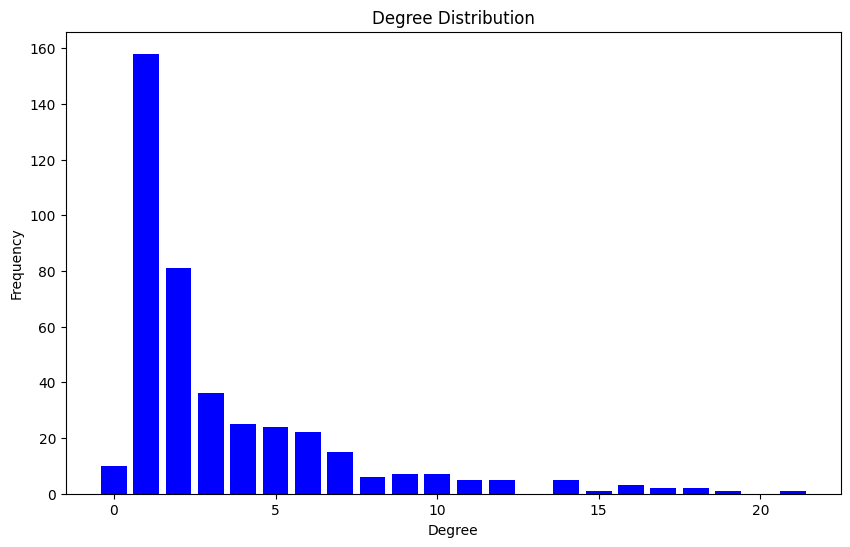

In [60]:
# compare calculated d and r values with actual values
analyze_graph(ana_model)

In [61]:
nx.degree_assortativity_coefficient(ana_model)

-0.3948683104036924

In [62]:
# get a degree distribution from BerlinFriedrichshain
bf_degrees = [bf_net.degree(n) for n in bf_net.nodes()]
bf_degree_counts = np.bincount(bf_degrees)

In [63]:
# make that random model with that
bf_graph = configuration_B(224, bf_degree_counts)

In [64]:
bf_graph_avg = nx.average_clustering(bf_graph)

In [65]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.1915
bf_model, bf_i, bf_c_steps = model3(bf_graph, bf_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.03 seconds


In [66]:
bf_model

In [67]:
bf_i

4464

In [68]:
bf_c_steps

[0.00043966450216450213,
 0.051052295918367345,
 0.021045918367346945,
 0.05846797052154194,
 0.040071956813028234,
 0.08766459235209234,
 0.06979327715934856,
 0.04872922216672215,
 0.060775385328956766,
 0.03564300283050283,
 0.07010947881483597,
 0.061259053446553434,
 0.09369484681984681,
 0.07040935255220969,
 0.06732773674737957,
 0.05885855216212356,
 0.03867479246943533,
 0.05864329123257694,
 0.05189770546913403,
 0.04630552978767261,
 0.04217848124098123,
 0.06579682718075575,
 0.05649370470799042,
 0.03855712739641311,
 0.053616745357816784,
 0.05539418418882706,
 0.07175840032982887,
 0.08583958204493916,
 0.052381175372246805,
 0.04494894985966414,
 0.06055274090988375,
 0.07306189594136023,
 0.07290626040626039,
 0.0504950654504226,
 0.0692896389324961,
 0.06060177421784563,
 0.09026620700727843,
 0.07304221076542503,
 0.0643794449598021,
 0.06324640141604425,
 0.048395528083028064,
 0.057984574948860654,
 0.05777838233195375,
 0.029547312806241375,
 0.06343391231784087,


Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 9
Average Clustering Coefficient: 0.05554472808937092


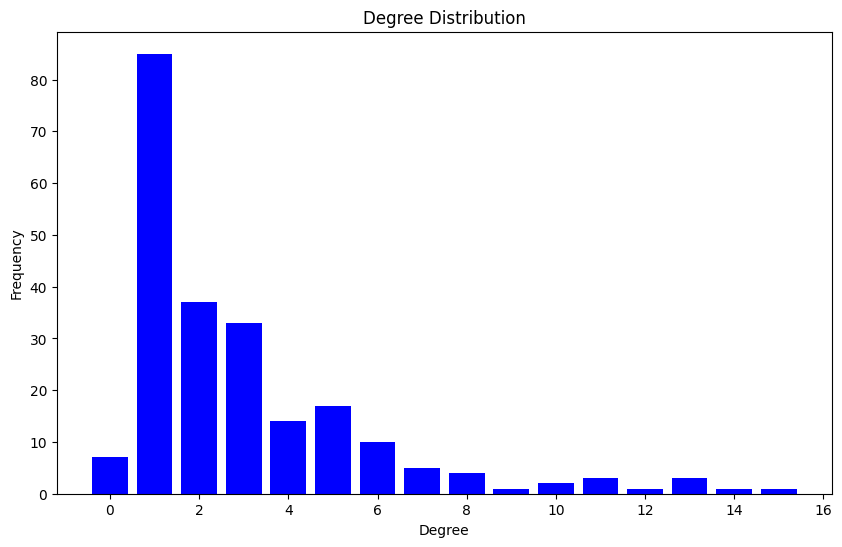

In [69]:
# compare calculated d and r values with actual values
analyze_graph(bf_model)

In [70]:
nx.degree_assortativity_coefficient(bf_model)

-0.32339740371345105

In [71]:
# get a degree distribution from Berlin-Mitte-Center
bmc_degrees = [bmc_net.degree(n) for n in bmc_net.nodes()]
bmc_degree_counts = np.bincount(bmc_degrees)

In [72]:
# make that random model with that
bmc_graph = configuration_B(398, bmc_degree_counts)

In [73]:
bmc_graph_avg = nx.average_clustering(bmc_graph)

In [74]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.2048
bmc_model, bmc_i, bmc_c_steps = model3(bmc_graph, bmc_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 3600.05 seconds


In [75]:
bmc_model

In [76]:
bmc_i

1205

In [77]:
bmc_c_steps

[0.001016989710457047,
 0.03511261212266236,
 0.040066019965517445,
 0.040516616270385095,
 0.03458925217719188,
 0.04409685791595339,
 0.03178521440788659,
 0.029419659067900266,
 0.04746810015218622,
 0.053539681325670115,
 0.05088921818156225,
 0.027548437702147426,
 0.049697867077528546,
 0.038269849997606416,
 0.06673755033646596,
 0.05692816396333984,
 0.07206428617528234,
 0.043410709154871135,
 0.05712510445579819,
 0.061063315523114524,
 0.0474631454530952,
 0.05869739679967289,
 0.05311735562330645,
 0.050047760013805384,
 0.04399368337149347,
 0.03848900959453723,
 0.03258322580300115,
 0.06149239017625065,
 0.04988841554837165,
 0.08123967248634706,
 0.06847959585622358,
 0.062274550203941764,
 0.05048919093484023,
 0.0645467819204148,
 0.05139238204564839,
 0.054003675652360215,
 0.05674728493757851,
 0.04912053257904027,
 0.060643943126207384,
 0.06082196902844258,
 0.05173815370755956,
 0.054480317963951294,
 0.047619537303833386,
 0.06899217477106924,
 0.051274465754956

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 8
Average Clustering Coefficient: 0.061218709224216655


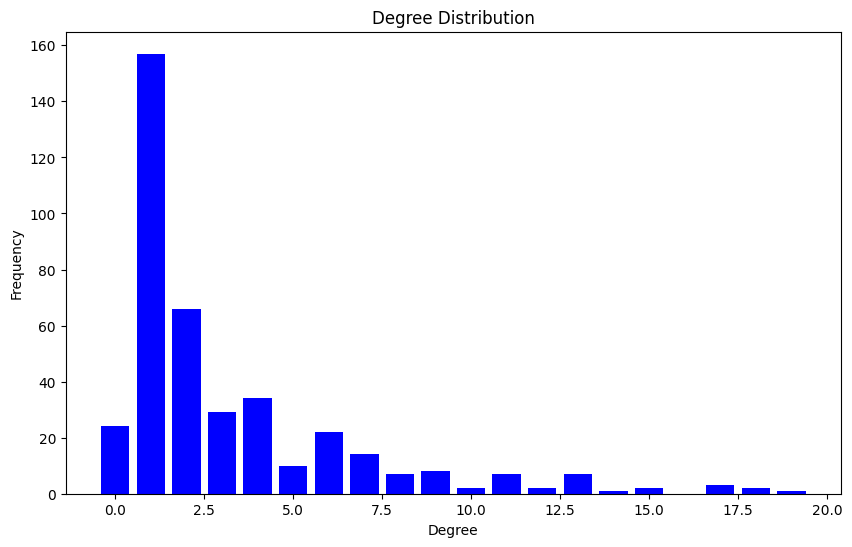

In [78]:
# compare calculated d and r values with actual values
analyze_graph(bmc_model)

In [79]:
nx.degree_assortativity_coefficient(bmc_model)

-0.4169771956115624